In [1]:
import pandas as pd
#import from pypi
import tqdm
import torch
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#local import
from radia.models.CNN import CNN
from radia.Metrics import Metrics
from radia.dataloaders.CXRLoader import CXRLoader
from radia.inference.inference import infer_loop,load_model
from radia import names,hierarchy

for key in hierarchy.keys():
    if key not in names :
        names.insert(0,key)

In [3]:
criterion = torch.nn.BCEWithLogitsLoss()
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    warnings.warn("No gpu is available for the computation")

# ----- parsing arguments -------------------------------------
#start = torch.cuda.Event(enable_timing=True)
#end = torch.cuda.Event(enable_timing=True)
# ------loading test set --------------------------------------
#img_dir = os.environ["img_dir"]
img_dir="E:"
os.environ["DEBUG"]="True"
test_dataset = CXRLoader("Valid",img_dir, img_size=384,channels=3,datasets=["ChexPert"],prob=[0,]*5)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=24,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)


CRITICAL:root:Server not available ; switching offline
c:\users\joeda\pycharmprojects\ia-med_img\radia\dataloaders\CXRLoader.py:244: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby("Exam ID").mean().round(0)


In [4]:
# ----------------loading model -------------------------------
models = [
        CNN("convnext_base_384_in22ft1k", channels=3, num_classes=len(names), pretrained=False, hierarchical=True),

    ]
    # model =  torch.nn.parallel.DistributedDataParallel(model)

    # api = wandb.Api()
    # run = api.run(f"ccsmtl2/Chestxray/{args.run_id}")
    # run.file("models_weights/convnext_base/DistributedDataParallel.pt").download(replace=True)
weights = [
        "C:/Users/joeda/PycharmProjects/IA-MED_IMG/data/model_weights/atomic-wildflower.pt",

    ]


models=load_model(weights=weights,models=models)
i=0

In [5]:

#start.record()
import time
start = time.time()
results = torch.zeros((len(test_dataset),len(names)))
for ex,model in enumerate(models) :
    model = model.to(device)
    running_loss, result = infer_loop(model=model, loader=test_loader, criterion=criterion, device=device)
    model = model.to("cpu")
    if ex==0 :
        results = result[1]
    else :
        results = torch.min(results,result[1])
#end.record()
end=time.time()
#torch.cuda.synchronize()
#print("time : ", start.elapsed_time(end))
print(end-start)
#plt.imshow(np.sum(heatmaps[0][0].detach().cpu().numpy(), axis=0))
#plt.savefig("heatmaps.png")

metric = Metrics(num_classes=len(names), names=names, threshold=np.zeros((len(names))) + 0.5)
metrics = metric.metrics()
metrics_results = {}
for key in metrics:
    pred = results.numpy()
    true = result[0].numpy().round(0)
    metric_result = metrics[key](true, pred)
    metrics_results[key] = metric_result

print(metrics_results)
i=0

100%|██████████| 9/9 [00:09<00:00,  1.05s/it]

9.478096008300781
(200, 10)
{'auc': {'Enlarged Cardiomediastinum': 0.5190977443609023, 'Cardiomegaly': 0.7375621890547263, 'Pleural Effusion': 0.9141773897058824, 'Pneumothorax': 0.8015463917525774, 'Lung Opacity': 0.897167487684729, 'Atelectasis': 0.8274133333333333, 'Pneumonia': 0.923828125, 'Consolidation': 0.8688616071428572, 'Edema': 0.8738698010849909, 'No Finding': 0.7975243147656941, 'mean': 0.8161048383885694}, 'f1': {'Enlarged Cardiomediastinum': 0.6885245901639345, 'Cardiomegaly': 0.54421768707483, 'Pleural Effusion': 0.6976744186046512, 'Pneumothorax': 0.072992700729927, 'Lung Opacity': 0.7862068965517242, 'Atelectasis': 0.6075949367088608, 'Pneumonia': 0.0837696335078534, 'Consolidation': 0.3106796116504854, 'Edema': 0.3980582524271844, 'No Finding': 0.9304812834224598, 'mean': 0.5120200010841911}, 'recall': {'Enlarged Cardiomediastinum': 1.0, 'Cardiomegaly': 0.6060606060606061, 'Pleural Effusion': 0.9375, 'Pneumothorax': 0.8333333333333334, 'Lung Opacity': 0.9827586206896

100%|██████████| 128/128 [00:08<00:00, 15.40it/s]


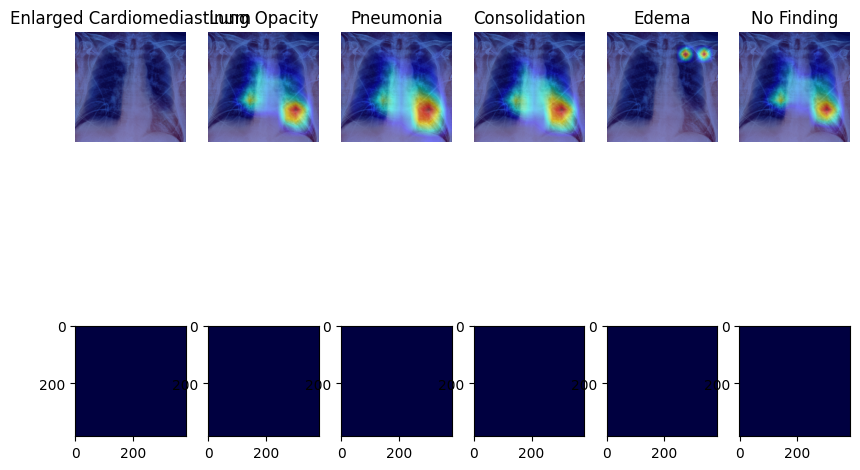

                               preds  ground-truth
Enlarged Cardiomediastinum  0.826850           0.0
Cardiomegaly                0.439254           0.0
Pleural Effusion            0.515935           0.0
Pneumothorax                0.611961           0.0
Lung Opacity                0.735135           0.0
Atelectasis                 0.598219           0.0
Pneumonia                   0.971343           0.0
Consolidation               0.893168           0.0
Edema                       0.762510           0.0
No Finding                  0.928186           0.0


100%|██████████| 128/128 [00:08<00:00, 15.38it/s]


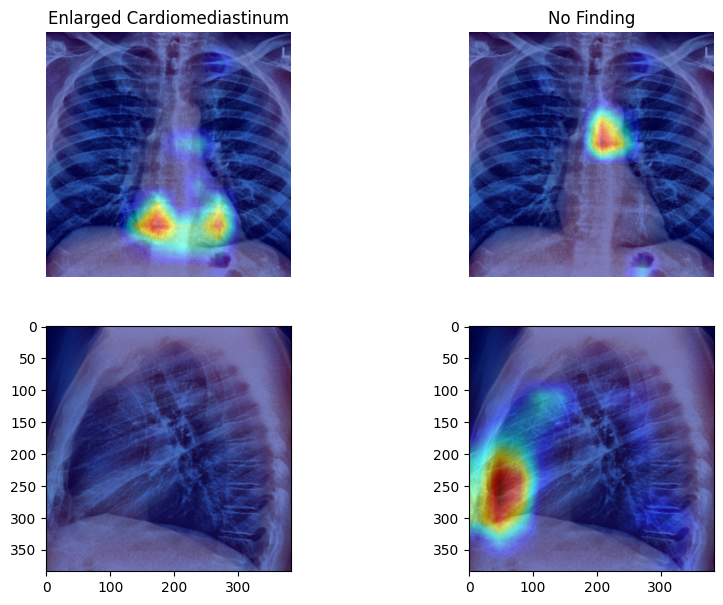

                               preds  ground-truth
Enlarged Cardiomediastinum  0.810179           0.0
Cardiomegaly                0.079510           0.0
Pleural Effusion            0.322743           0.0
Pneumothorax                0.299038           0.0
Lung Opacity                0.328158           0.0
Atelectasis                 0.159724           0.0
Pneumonia                   0.236387           0.0
Consolidation               0.535144           0.0
Edema                       0.023981           0.0
No Finding                  0.687972           0.0


 89%|████████▉ | 114/128 [00:07<00:00, 15.13it/s]

In [ ]:

#inputs,labels=test_dataset[i]
#Manually loading images
import cv2 as cv
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import FullGrad,EigenCAM,GradCAM,HiResCAM,GradCAMPlusPlus,ScoreCAM
from PIL import Image

model = models[0] # only using 1 model, not an Ensemble
model = model.to(device)
cams=[
    #FullGrad(model,target_layers=[]), #crashes
    #EigenCAM(model,target_layers=[model.backbone.stages[-1 , #same as gradcam
    #GradCAM(model,target_layers=[model.backbone.stages[-1]]),
    #HiResCAM(model,target_layers=[model.backbone.stages[-1]]),
    ScoreCAM(model,target_layers=[model.backbone.stages[-1]],use_cuda=True),
]
cam=cams[-1]
setattr(cams[-1],"batch_size",8)
img_size=384
for i in range(0,10) :
    inputs,labels,idx = test_dataset[i]
    inputs = inputs[None,:,:,:]
    inputs = inputs.to(device,non_blocking=True)
    # forward + backward + optimize
    outputs = model(inputs)
    model.hierarchical=False
    channels=3

    img0=inputs[0:1,0*channels : (0+1)*channels,:,:]

    img1=inputs[0:1,1*channels : (1+1)*channels,:,:]
    # create figure
    fig = plt.figure(figsize=(10, 7))

    img = test_dataset.read_img(i)
    channels=3
    img0_display=img[:,:,0:channels].astype(np.uint8)

    img1_display=img[:,:,channels:2*channels].astype(np.uint8)
    if channels ==1 :
        img0_display = cv.cvtColor(img0_display,cv.COLOR_GRAY2RGB)
        img1_display=cv.cvtColor(img1_display,cv.COLOR_GRAY2RGB)

    rows=2


    targets = [ClassifierOutputTarget(i) for i,output in enumerate(outputs.squeeze().cpu().tolist()) if output>0.7]
    targets_idx = [i for i,output in enumerate(outputs.squeeze().cpu().tolist()) if output>0.7]
    columns=len(targets)
    for ex,target in enumerate(targets,start=1) :
        heatmap0 = cam(img0.float(),targets=[target]).squeeze() * -255+255

        heatmap1 = cam(img1.float(),targets=[target]).squeeze() * -255+255


        #heatmap0 = np.where(heatmap0<0.9,0,heatmap0)
        #heatmap1 = np.where(heatmap0<0.9,0,heatmap1)
        fig.add_subplot(rows, columns, ex)
        heatmap0 = np.array(cv.applyColorMap(cv.cvtColor(heatmap0[:, :,None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))


        heatmap0 = cv.addWeighted(heatmap0, 0.5, img0_display, 0.5, 0)

        plt.imshow(heatmap0.squeeze())
        plt.axis('off')
        plt.title(names[targets_idx[ex-1]])


        fig.add_subplot(rows, columns, len(targets)+ex)
        heatmap1 = np.array(cv.applyColorMap(cv.cvtColor(heatmap1[:, :,None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))
        heatmap1 = cv.addWeighted(heatmap1, 0.5, img1_display, 0.5, 0)
        plt.imshow(heatmap1.squeeze())

    plt.savefig(f"heatmap_{i}_per_target")

    plt.show()
    # plt.imshow(img0_display)
    # plt.show()
    # plt.imshow(img1_display)
    # plt.show()
    #Image.fromarray(heatmap0).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_frontal.jpg")
    #Image.fromarray(heatmap1).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_lateral.jpg")


    #loss = criterion(outputs.squeeze(), labels)
    outputs = torch.sigmoid(outputs)

    data=pd.DataFrame([outputs.cpu().detach().numpy().squeeze(),labels.cpu().numpy().squeeze()],columns=names,index=["preds","ground-truth"])

    print(data.T)

